In [40]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/




## IMPORT LIBRARIES

In [41]:
import torch
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
from sklearn.datasets import make_moons
import pandas as pd
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
import requests
from pathlib import Path

In [42]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Make a binary classification dataset with Scikit-Learn's make_moons() function.
* For consistency, the dataset should have 1000 samples and a random_state=42.
* Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [43]:
X, y= make_moons(n_samples=1000, random_state=42)

In [44]:
X.shape, y.shape

((1000, 2), (1000,))

In [45]:
X[: 5], y[: 5]

(array([[ 0.00872719,  0.36817352],
        [ 0.921384  , -0.49690497],
        [ 0.94022577, -0.49821192],
        [ 0.46587532, -0.34540571],
        [-0.85041204,  0.52611726]]),
 array([1, 1, 1, 1, 0]))

In [46]:
df= pd.DataFrame({'X1': X[:,0], 'X2': X[:,1], 'Y': y})
df.head()

,X1,X2,Y
0,0.008727,0.368174,1
1,0.921384,-0.496905,1
2,0.940226,-0.498212,1
3,0.465875,-0.345406,1
4,-0.850412,0.526117,0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      1000 non-null   float64
 1   X2      1000 non-null   float64
 2   Y       1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [48]:
df['Y'].value_counts()

1    500
0    500
Name: Y, dtype: int64

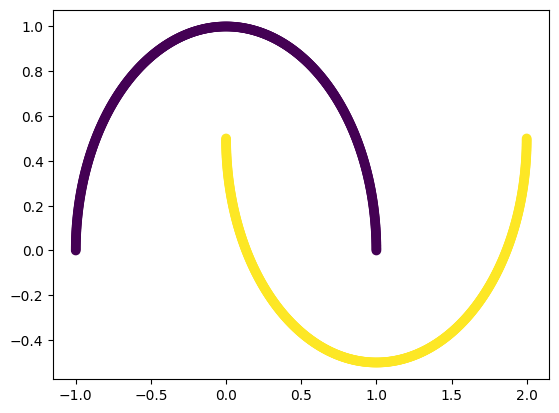

In [49]:
# Visualizing the data
plt.scatter(df['X1'], df['X2'], c= df['Y'], )

In [50]:
# Turn the data into tensors
X= torch.tensor(X, dtype= torch.float).to(device)
y= torch.tensor(y, dtype= torch.float).to(device)

In [51]:
X[:4], y[:4]

(tensor([[ 0.0087,  0.3682],
         [ 0.9214, -0.4969],
         [ 0.9402, -0.4982],
         [ 0.4659, -0.3454]]),
 tensor([1., 1., 1., 1.]))

In [52]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [53]:
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.2, random_state=42)
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

## Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
* Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [54]:
class MoonModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.model= nn.Sequential(
        nn.Linear(in_features=2, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=1)
       )
  def forward(self, x):
    return self.model(x)

model= MoonModel().to(device)
model

MoonModel(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

Setup a binary classification compatible loss function and optimizer to use when training the model.

In [55]:
loss_fn= nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(
    model.parameters(), lr=0.1
)


Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
* To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
* Train the model for long enough for it to reach over 96% accuracy.
* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy

In [56]:
model.eval()
with torch.inference_mode():
  a= model(X_test)
a[: 2]

tensor([[0.0322],
        [0.0293]])

In [57]:
torch.sigmoid(a[: 2])

tensor([[0.5080],
        [0.5073]])

In [58]:
y_test[: 2]

tensor([1., 0.])

In [59]:
def acc_fn(y_true, y_pred):
  corr= torch.eq(y_true, y_pred).sum().item()
  acc= (corr/len(y_pred))*100
  return acc

In [60]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs= 100

for i in range(epochs):
  model.train()
  y_logits= model(X_train).squeeze()
  y_preds= torch.round(torch.sigmoid(y_logits))
  loss= loss_fn(y_logits, y_train)
  acc= acc_fn(y_preds, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # testing
  model.eval()
  with torch.inference_mode():
    test_logits= model(X_test).squeeze()
    test_pred= torch.round(torch.sigmoid(test_logits))
    test_acc= acc_fn(test_pred, y_test)
    test_loss= loss_fn(test_logits, y_test)

  if i % 10 == 0:
    print (f'Epochs {i} | Loss {loss:.5f} | acc {acc:.2f}% | test loss {test_loss:.5f} | test acc: {test_acc:.2f}%')
             

Epochs 0 | Loss 0.69536 | acc 37.25% | test loss 0.64255 | test acc: 64.50%
Epochs 10 | Loss 0.25953 | acc 87.50% | test loss 0.23884 | test acc: 90.00%
Epochs 20 | Loss 0.19809 | acc 91.25% | test loss 0.17400 | test acc: 92.50%
Epochs 30 | Loss 0.08066 | acc 98.50% | test loss 0.06149 | test acc: 99.50%
Epochs 40 | Loss 0.00453 | acc 100.00% | test loss 0.00317 | test acc: 100.00%
Epochs 50 | Loss 0.00042 | acc 100.00% | test loss 0.00041 | test acc: 100.00%
Epochs 60 | Loss 0.00014 | acc 100.00% | test loss 0.00013 | test acc: 100.00%
Epochs 70 | Loss 0.00008 | acc 100.00% | test loss 0.00008 | test acc: 100.00%
Epochs 80 | Loss 0.00006 | acc 100.00% | test loss 0.00006 | test acc: 100.00%
Epochs 90 | Loss 0.00005 | acc 100.00% | test loss 0.00005 | test acc: 100.00%


In [61]:
y_test[: 10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

In [62]:
model.eval()
with torch.inference_mode():
  y_logits= model(X_test)
  y_preds= torch.round(torch.sigmoid(y_logits)).squeeze()

y_preds[: 10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [63]:
if Path('helper_functions.py').is_file():
  print('helper fn already exist')
else:
  print('downloading helper function')
  request= requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_function.py', 'wb') as f:
    f.write(request.content)

downloading helper function


In [64]:
from helper_function import plot_decision_boundary

Text(0.5, 1.0, 'Test')

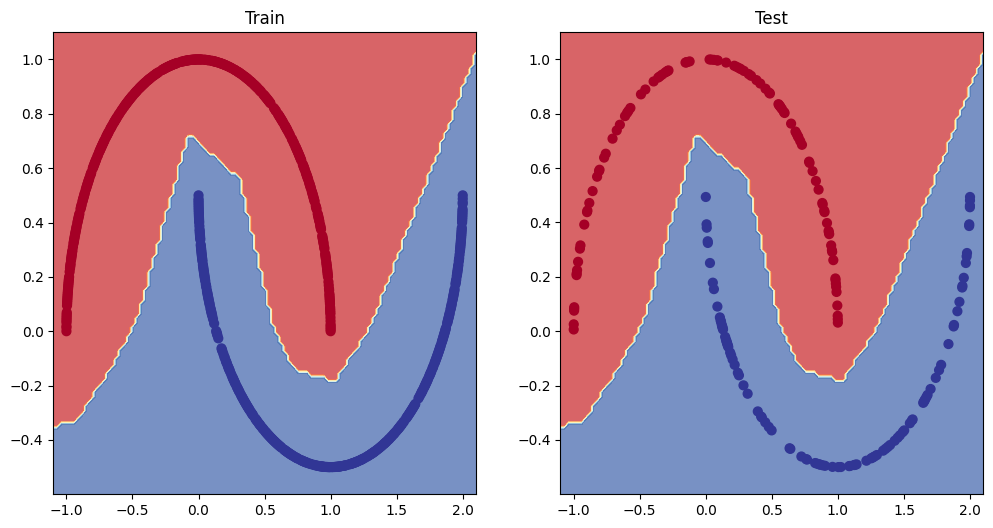

In [65]:
plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plot_decision_boundary(model, X_test, y_test)
plt.title('Test')

## ASSESSMENT 2

Create a multi-class dataset using the spirals data creation function from CS231n.
* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
* Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

## Creating Spiral Dataset

In [66]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class label
X.shape, y.shape

((300, 2), (300,))

In [67]:
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
X[: 5]

array([[-0.        ,  0.        ],
       [-0.00194002,  0.00991296],
       [-0.00708146,  0.01892022],
       [-0.00548525,  0.02980244],
       [ 0.02032365,  0.03492042]])

In [68]:
m= pd.DataFrame({'shj': y})
m['shj'].value_counts()

0    100
1    100
2    100
Name: shj, dtype: int64

## Exploring Dataset

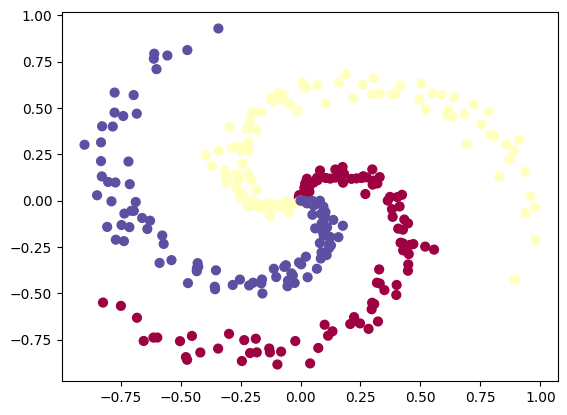

In [69]:
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [70]:
X= torch.Tensor(X).to(device)
y= torch.Tensor(y).type(torch.long).to(device)

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([240, 2]),
 torch.Size([60, 2]),
 torch.Size([240]),
 torch.Size([60]))

In [72]:
y.dtype

torch.int64

## BUILDING MODEL

In [73]:
class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.model= nn.Sequential(
        nn.Linear(in_features=2, out_features=10),
        nn.Sigmoid(),
        nn.Linear(in_features=10, out_features=10),
        nn.Sigmoid(),
        nn.Linear(in_features=10, out_features=3)
       )
  def forward(self, x):
    return self.model(x)

model_2= SpiralModel().to(device)
model_2

SpiralModel(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [74]:
model_2.eval
with torch.inference_mode():
  y_logits= model_2(X_test)

torch.softmax(y_logits[: 2], dim=1).argmax(dim=1)

tensor([2, 2])

In [75]:
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model_2.parameters(), lr=0.1)

In [76]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs= 200

for i in range(epochs):
  model_2.train()
  y_logits= model_2(X_train)
  y_preds= torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss= loss_fn(y_logits, y_train)
  acc= acc_fn(y_preds, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # testing
  model_2.eval()
  with torch.inference_mode():
    test_logits= model_2(X_test)
    test_pred= torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_acc= acc_fn(test_pred, y_test)
    test_loss= loss_fn(test_logits, y_test)

  if i % 20 == 0:
    print (f'Epochs {i} | Loss {loss:.5f} | acc {acc:.2f}% | test loss {test_loss:.5f} | test acc: {test_acc:.2f}%')
             

Epochs 0 | Loss 1.11628 | acc 32.50% | test loss 1.20518 | test acc: 26.67%
Epochs 20 | Loss 0.88541 | acc 54.58% | test loss 0.86734 | test acc: 53.33%
Epochs 40 | Loss 0.60906 | acc 66.67% | test loss 0.71268 | test acc: 56.67%
Epochs 60 | Loss 0.31615 | acc 87.08% | test loss 0.35754 | test acc: 88.33%
Epochs 80 | Loss 0.10393 | acc 97.50% | test loss 0.07753 | test acc: 100.00%
Epochs 100 | Loss 0.05827 | acc 98.33% | test loss 0.03003 | test acc: 100.00%
Epochs 120 | Loss 0.04504 | acc 98.75% | test loss 0.01598 | test acc: 100.00%
Epochs 140 | Loss 0.03819 | acc 98.75% | test loss 0.01063 | test acc: 100.00%
Epochs 160 | Loss 0.03364 | acc 99.17% | test loss 0.00805 | test acc: 100.00%
Epochs 180 | Loss 0.03044 | acc 99.17% | test loss 0.00605 | test acc: 100.00%


## Evaluating the Model

Text(0.5, 1.0, 'Test')

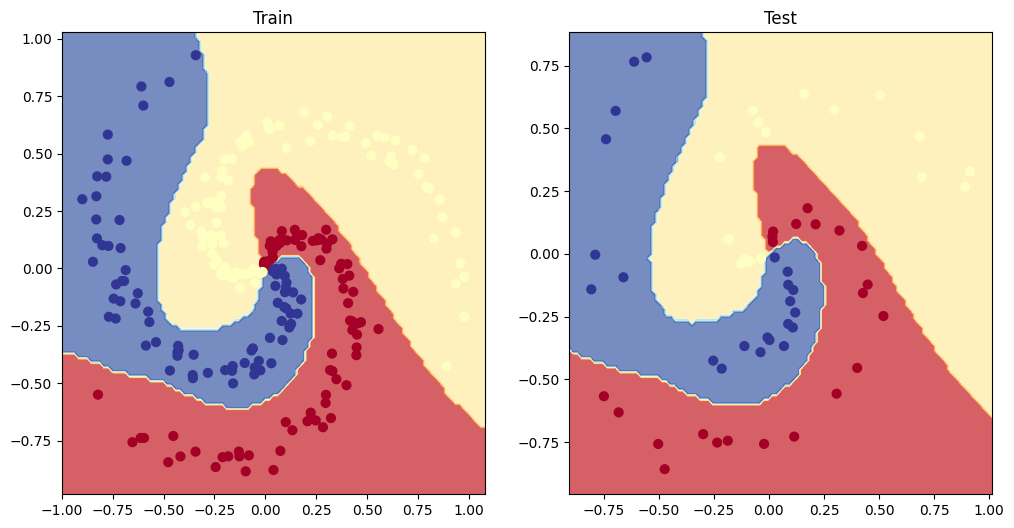

In [77]:
plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1,2,2)
plot_decision_boundary(model_2, X_test, y_test)
plt.title('Test')